In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
inspector = inspect(engine)

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

Mea_columns = inspector.get_columns('measurement')
print("Measurements:")
for c in Mea_columns:
    print(c['name'], c["type"])
   
print("-------------------")
print("Station:")
sta_columns = inspector.get_columns('station')
for c in sta_columns:
    print(c['name'], c["type"])

Measurements:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------------------
Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

year_ago = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

year_ago_df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all())

per_df = year_ago_df.set_index("date")

per_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


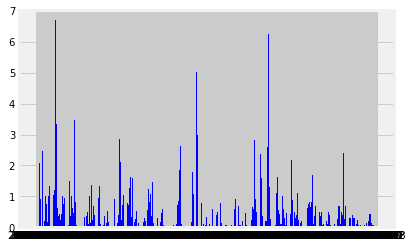

In [11]:
x_axis = per_df.index
y_axis = per_df["prcp"]

plt.bar(x_axis, y_axis, color="b", align="center")

plt.show()


In [12]:
summary = per_df.describe()
summary

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

count_= session.query(Measurement.date).order_by(Measurement.date.desc()).first()

station_count = session.query(Station.station).count()

station_count

station_list = session.query(Station.station).all()
station_list

my_list = [('USC00519397'),('USC00513117'),('USC00514830'),('USC00517948'),('USC00518838'),('USC00519523'),('USC00519281'),
('USC00511918'),('USC00516128')]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

engine.execute('SELECT station, count(station) FROM Measurement GROUP BY station ORDER BY count(station) DESC').fetchall()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#engine.execute('SELECT min(tobs), max(tobs), avg(tobs) FROM Measurement').fetchall()

Chosen_one = pd.DataFrame(session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').all())

print(Chosen_one.max())
print(Chosen_one.min())
print(Chosen_one.mean())

station    USC00519281
tobs                85
dtype: object
station    USC00519281
tobs                54
dtype: object
tobs    71.663781
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B8BD50550>]],
      dtype=object)

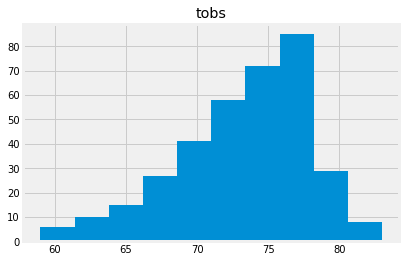

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Last_Year = pd.DataFrame(session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281', Measurement.date > '2016-08-23' ).all())

Last_Year.head()

Last_Year.hist()

![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Vacation Period = '2018-03-23', '2018-03-30'

my_trip = calc_temps('2017-03-23', '2017-03-30')

first_day = '2017-03-23'
last_day = '2017-03-30'

print(my_trip)
min_temp = my_trip[0][0]
avg_temp = my_trip[0][1]
max_temp = my_trip[0][2]

[(68.0, 74.375, 80.0)]


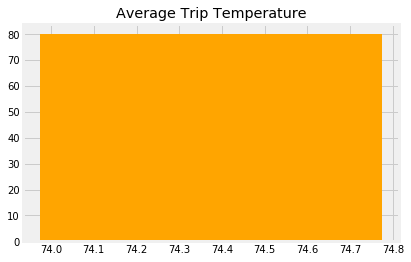

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
import numpy as np

Temps = [0,20,40,60,80]

plt.bar(avg_temp, Temps, align='center', color = "orange")
plt.title('Average Trip Temperature')

plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#session.query(func.sum(Measurement.prcp)).\
#        filter(Measurement.date >= '2017-03-23').filter(Measurement.date <= '2017-03-30').all()

engine.execute('SELECT station, sum(prcp) FROM Measurement  GROUP BY station ORDER BY sum(prcp) DESC').fetchall()
